In [80]:
!pip install av miditok py_midicsv

^C
ERROR: Operation cancelled by user


In [81]:
!pip list | grep transformers
!ls /opt/conda/lib/python3.10/site-packages/ | grep transformer

UnboundLocalError: local variable 'child' referenced before assignment

In [ ]:
!pip uninstall -y transformers
!pip install --no-cache-dir git+https://github.com/ellemcfarlane/transformers.git

In [ ]:
!pip list | grep transformers
!ls /opt/conda/lib/python3.10/site-packages/ | grep transformer

In [ ]:
# !pip list
!pip show transformers

In [ ]:
# import sys
# sys.path.insert(0, '/opt/conda/lib/python3.10/site-packages/transformers-4.40.0.dev0-py3.10.egg')
import transformers
print(transformers.__version__)

In [ ]:
# Name: transformers
# Version: 4.40.0.dev0
# Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
# Home-page: https://github.com/huggingface/transformers
# Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
# Author-email: transformers@huggingface.co
# License: Apache 2.0 License
# Location: /opt/conda/lib/python3.10/site-packages
# Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
# Required-by: kaggle-environments

In [ ]:
import av
import numpy as np

from transformers import VivitImageProcessor, VivitModel, VivitConfig, TransfoXLLMHeadModel, TransfoXLConfig
from huggingface_hub import hf_hub_download
print(transformers.__version__)
import matplotlib.pyplot as plt
from torch import nn
import py_midicsv as pm
import torch
import torch.nn.functional as F

from PIL import Image
import os
from miditok import REMI, TokenizerConfig  # here we choose to use REMI
import miditok
from pathlib import Path
np.random.seed(0)


In [ ]:
# elle
def read_frames_from_path(frames_path, indices, rgb=False):
    '''
    Read specific frames from a directory containing image files of video frames.
    Args:
        frames_path (str): Path to the directory containing frame images.
        indices (List[int]): List of frame indices to read.
    Returns:
        result (np.ndarray): numpy array of frames of shape (num_frames, height, width, 3).
    '''
    # List all files in the directory and sort them to maintain order
    all_files = sorted(os.listdir(frames_path))
    frames = []

    # Process only files at specific indices
    color_mode = 'RGB' if rgb else 'L'
    for idx in indices:
        if idx < len(all_files):
            file_path = os.path.join(frames_path, all_files[idx])
            with Image.open(file_path) as img:
                # Convert image to RGB to ensure consistency
                img = img.convert(color_mode)
                # Calculate differences to make the image square
                width, height = img.size
                max_side = max(width, height)
                # Create a new image with a black background
                new_img = Image.new(color_mode, (max_side, max_side))
                # Paste the original image onto the center of the new image
                new_img.paste(img, ((max_side - width) // 2, (max_side - height) // 2))
                frame_array = np.array(new_img)
                if color_mode == 'L':
                    # Expand dims to add the channel dimension, resulting in (H, W, 1)
                    frame_array = np.expand_dims(frame_array, axis=-1)
                frames.append(frame_array)

    stacked_frames = np.stack(frames, axis=0)
    return stacked_frames

def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])

def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

In [ ]:
# # video clip consists of 300 frames (10 seconds at 30 FPS)
# file_path = hf_hub_download(
#     repo_id="nielsr/video-demo", filename="eating_spaghetti.mp4", repo_type="dataset"
# )
# container = av.open(file_path)

In [ ]:
# sample 32 frames
# indices = sample_frame_indices(clip_len=1, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
# video = read_video_pyav(container=container, indices=indices)
ds_dir = "../input/twinkle-fixed/data_sanity"
frames_path = f"{ds_dir}/processed/frames/somebody--twinke_twinkle_0"
video = read_frames_from_path(frames_path=frames_path, indices=range(32))

In [ ]:
video.shape

In [ ]:
# image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")
# model_enc = VivitModel.from_pretrained("google/vivit-b-16x2-kinetics400")
image_processor = VivitImageProcessor(image_mean=[.5], image_std=[.5])

In [ ]:
print(image_processor)

In [ ]:
img_side_width = 64
img_size = (img_side_width,img_side_width)
print(video.shape, type(video))
inputs = image_processor(list(video), return_tensors="pt", do_center_crop=False, do_resize=True, size=img_size)
print(inputs["pixel_values"].shape)

In [ ]:
# ([1, 32, 3, 224, 224]) for their examples this is the shape of the input tensor

In [ ]:
# show the inputs  as a 2x3 grid skipping the 6th frame
fig, ax = plt.subplots(2, 3, figsize=(6, 4))
for i in range(5):
    ax[i // 3, i % 3].imshow(inputs["pixel_values"][0, i].permute(1, 2, 0).numpy(), cmap='gray')
    ax[i // 3, i % 3].axis("off")

In [ ]:
# Our parameters
TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": {(0, 4): 8, (4, 12): 4},
    "num_velocities": 32,
    "special_tokens": ["PAD", "BOS", "EOS", "MASK"],
    "use_chords": True,
    "use_rests": False,
    "use_tempos": True,
    "use_time_signatures": False,
    "use_programs": False,
    "num_tempos": 32,  # number of tempo bins
    "tempo_range": (40, 250),  # (min, max)
}
config = TokenizerConfig(**TOKENIZER_PARAMS)

# Creates the tokenizer
tokenizer = REMI(config)

In [ ]:
print(len(tokenizer.vocab))

In [ ]:
# midi_file = "/Users/ellemcfarlane/Documents/dtu/ai-synth/data_sanity/processed/midi/somebody--twinke_twinkle_0.mid"
midi_file = f"{ds_dir}/processed/midi/somebody--twinke_twinkle_0.mid"
tokens = tokenizer(Path(midi_file))  # automatically detects Score objects, paths, tokens
print(tokens, type(tokens[0]))
re_enc_tokens = tokenizer(tokenizer(tokens))
for token in re_enc_tokens:
    for t, id in zip(token.tokens, token.ids):
        print(t, id)

In [ ]:
# midi_file = "/Users/ellemcfarlane/Documents/dtu/ai-synth/data_sanity/processed/midi/somebody--twinke_twinkle_0.mid"
midi_file = f"{ds_dir}/processed/midi/somebody--twinke_twinkle_0.mid"
tokens = tokenizer(Path(midi_file))  # automatically detects Score objects, paths, tokens
print(len(tokens), len(tokens[0]))
token_ids = [tokens[0].ids]
print(token_ids)
decoded_tokens = tokenizer(token_ids)
re_enc_tokens = tokenizer(decoded_tokens)
for token in re_enc_tokens:
    for t, id in zip(token.tokens, token.ids):
        print(t, id)

In [ ]:
torch.save(tokens[0].ids, 'input_token_ids')

In [ ]:
csv_string = pm.midi_to_csv(f"{ds_dir}/processed/midi/somebody--twinke_twinkle_1.mid")

for line in csv_string:
    print(line)

In [ ]:
# csv_string = pm.midi_to_csv(f"{ds_dir}/processed/midi/somebody--twinke_twinkle_1.mid")

# for line in csv_string:
#     print(line)

In [ ]:
# midi_file = f"{ds_dir}/processed/midi/somebody--twinke_twinkle_1.mid"
for idx in range(6):
    midi_file = f"{ds_dir}/processed/midi/somebody--twinke_twinkle_{idx}.mid"
    tokens = tokenizer(Path(midi_file))  # automatically detects Score objects, paths, tokens
    for token in tokens:
        for idx, (t, id) in enumerate(zip(token.tokens, token.ids)):
            if idx == 2:
                print(t, id)

In [ ]:
print(32*3*224**2)
print(3*224**2)

In [ ]:
# print(model_enc)

In [ ]:
# forward pass
# outputs = model_enc(**inputs)
# last_hidden_states = outputs.last_hidden_state
# print(list(last_hidden_states.shape))

In [ ]:
# print(f"Number of parameters: {sum(p.numel() for p in model_enc.parameters())}")

In [ ]:
# from torch.profiler import profile, record_function, ProfilerActivity

# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True) as prof:
#     with record_function("model_inference"):
#         outputs = model(**inputs)
# print(prof.key_averages().table(sort_by="gpu_memory_usage", row_limit=10))


In [ ]:
class Encoder(nn.Module):
    def __init__(self, config):
        super(Encoder, self).__init__()
#         self.vivit = VivitModel.from_pretrained(pretrained_model_name)

        # Remove the classification head
#         self.vivit.classifier = nn.Identity()
        self.vivit = VivitModel(config)

    def forward(self, video_frames):
        # Assume video_frames is a tensor of shape (batch, channels, frames, height, width)
        outputs = self.vivit(video_frames)
        # We use the last hidden state
        return outputs.last_hidden_state


class Decoder(nn.Module):
    def __init__(self, config):
        super(Decoder, self).__init__()
        self.transformer_xl = TransfoXLLMHeadModel(config)

    def forward(self, hidden_states, labels):
        # We expect hidden_states to be of shape (batch_size, sequence_length, feature_size)
#         outputs = self.transformer_xl(inputs_embeds=hidden_states, labels=labels)
        outputs = self.transformer_xl(inputs_embeds=hidden_states, labels=labels)
        return outputs


class VideoToMIDISeq2Seq(nn.Module):
    def __init__(self, encoder_config, decoder_config):
        super(VideoToMIDISeq2Seq, self).__init__()
        self.encoder = Encoder(encoder_config)
        self.decoder = Decoder(decoder_config)

    def forward(self, inputs):
        encoder_outputs = self.encoder(inputs['pixel_values'])
        # model(**inputs, labels=inputs["input_ids"])
        decoder_outputs = self.decoder(encoder_outputs, labels=inputs['labels'])
        return decoder_outputs

In [ ]:
inputs['input_ids'] = torch.load('input_token_ids')

In [ ]:
tokenizer["EOS_None"]

In [ ]:
# input_ids = torch.tensor(torch.load('input_token_ids')).unsqueeze(0) # Suppose it's [2, 318, 1574]
# print(input_ids.shape)
# # Shift input_ids to create labels:
# labels = input_ids[:, 1:]  # Remove the first token, resulting in [318, 1574]
# print(labels.shape)
# # You might append an end-of-sequence token if your model setup requires it
# eos_token_id = tokenizer["EOS_None"]  # This is model and tokenizer specific
# labels = torch.cat([labels, torch.tensor([[eos_token_id]])], dim=1) 
# print(labels.shape)

In [ ]:
#   )
#   (crit): ProjectedAdaptiveLogSoftmax(
#     (out_layers): ModuleList(
#       (0): Linear(in_features=512, out_features=20000, bias=True)
#       (1): Linear(in_features=128, out_features=20000, bias=True)
#       (2): Linear(in_features=32, out_features=160000, bias=True)
#       (3): Linear(in_features=8, out_features=67735, bias=True)
#     )
#     (out_projs): ParameterList(
#         (0): Parameter containing: [torch.float32 of size 768x512]
#         (1): Parameter containing: [torch.float32 of size 768x128]
#         (2): Parameter containing: [torch.float32 of size 768x32]
#         (3): Parameter containing: [torch.float32 of size 768x8]
#     )
#   )

In [ ]:
# d_model = 768
# n_head = 8
# d_head = d_model // n_head
# d_embed=512
# d_inner=2048
# n_layer=1
# mem_len=512
# dropout=0.1
# d_model = 768
# n_head = 4
# d_head = d_model // n_head
# d_embed=512
# d_inner=1024
# n_layer=2
# mem_len=512//2
# dropout=0.1
# vocab_size = len(tokenizer.vocab)
# # cutoffs = [328]
# cutoffs = [150, 300]
# decoder_config = TransfoXLConfig(vocab_size=vocab_size, cutoffs=cutoffs, n_head=n_head, d_head=d_head, d_embed=d_embed, d_model=d_model, d_inner=d_inner, n_layer=n_layer, mem_len=mem_len, dropout=dropout)
# Assume you have already set the necessary parameters in the config
encoder_config = VivitConfig(
    image_size=64,  # Smaller size since high resolution is likely not necessary
    num_frames=32,  # Reduced frames if action is not too fast
    tubelet_size=[1, 8, 8],  # Smaller tubelet size for the specific task
    num_channels=1,  # Assuming the input is grayscale; change to 3 if it's in color
    hidden_size=512,  # Smaller hidden size for a potentially simpler model
    num_hidden_layers=6,  # Fewer layers to start with
    num_attention_heads=8,  # Fewer attention heads corresponding to the smaller hidden size
    intermediate_size=2048,  # 4 times the hidden_size
    hidden_act="gelu_fast",  # Default activation function
    hidden_dropout_prob=0.1,  # Slight dropout for generalization
    attention_probs_dropout_prob=0.1,  # Slight dropout in attention as well
    initializer_range=0.02,  # Standard initialization range
    layer_norm_eps=1e-6,  # Default layer norm epsilon
    qkv_bias=True  # Default bias for QKV in attention
)
decoder_config = TransfoXLConfig(
    vocab_size=328,  # Your MIDI token vocabulary size
    cutoffs=[],  # You might not need an adaptive softmax with a small vocabulary
    d_model=512,  # Lower dimensionality for a smaller model
    d_embed=512,  # Same as d_model if not using adaptive embeddings
    n_head=8,  # Fewer heads given the smaller model size
    d_head=32,  # Lower dimensionality of model heads
    d_inner=1024,  # Inner dimension of feed-forward layers
    div_val=1,  # Since the vocab is small, might not need adaptive input
    pre_lnorm=False,  # Default setting
    n_layer=6,  # Fewer layers than a large-scale model
    mem_len=128,  # Shorter memory length could suffice
    clamp_len=-1,  # Clamp len set to -1 to use default behavior
    same_length=False,  # Same length not necessary for smaller sequences
    proj_share_all_but_first=False,  # Only share projections if model size increases
    attn_type=0,  # Default Transformer-XL attention
    sample_softmax=-1,  # With small vocab, full softmax is manageable
    adaptive=False,  # No adaptive embeddings needed with small vocab
    dropout=0.1,  # Standard dropout rate
    dropatt=0.1,  # Attention dropout
    untie_r=True,  # Typically we untie the biases
    init="normal",  # Default initializer
    init_range=0.1,  # Slightly larger initialization range
    proj_init_std=0.1,  # Larger initialization for projections
    init_std=0.02,  # Default initialization for weights
    layer_norm_epsilon=1e-5,  # Default layer normalization epsilon
    eos_token_id=tokenizer["EOS_None"],  # If you have a specific EOS token, otherwise the default is typically fine
)

# Instantiate the model
model = VideoToMIDISeq2Seq(encoder_config=encoder_config, decoder_config=decoder_config)

print(model)

In [ ]:
# encoder_outputs = model.encoder(inputs['pixel_values'])

In [ ]:
# del encoder_outputs
# import gc

In [ ]:
# gc.collect()

In [ ]:
encoder_outputs_raw = model.encoder.vivit(inputs['pixel_values'])

In [ ]:
# encoder_outputs_raw

In [ ]:
encoder_outputs_raw.pooler_output.shape

In [ ]:
# torch.save(encoder_outputs, 'input.pt')

In [ ]:
# print(encoder_outputs.shape)
# print(inputs['pixel_values'].shape)

In [ ]:
encoder_outputs_raw.pooler_output.shape

In [ ]:
encoder_outputs_raw.last_hidden_state.shape

In [ ]:
# label_ids_tensor.shape

In [ ]:
encoder_outputs_raw.last_hidden_state.squeeze(0).shape

In [ ]:
label_ids_tensor = torch.tensor(inputs['input_ids']).unsqueeze(0)
print(transformers.__version__)
target_sequence_length = 51
# Apply adaptive average pooling along the sequence dimension to reduce it
decoder_inputs = F.adaptive_avg_pool1d(encoder_outputs_raw.last_hidden_state.squeeze(0).transpose(0, 1), target_sequence_length).transpose(0, 1).unsqueeze(0)
print(decoder_inputs.shape)
decoder_outputs = model.decoder(decoder_inputs, labels=None) #, labels=label_ids_tensor)

In [ ]:
decoder_outputs

TODO NEXT: check why the embedding output of the decoder isn't actually the sequence length, and also maybe we don't need to pass in the input_ids/labels

In [ ]:
# Convert logits to actual token IDs using argmax
predicted_token_ids = torch.argmax(decoder_outputs.prediction_scores, dim=-1)

In [ ]:
predicted_token_ids

In [ ]:
# dir(tokenizer)

In [ ]:
# tokenizer.vocab

In [ ]:
token_id_to_token = {v: k for k, v in tokenizer.vocab.items()}

In [ ]:
predicted_tokens = [token_id_to_token[int(id_.detach().numpy())] for id_ in predicted_token_ids[0]]

In [ ]:
predicted_tokens

In [ ]:
print(len(predicted_token_ids), len(predicted_token_ids[0]))
print(type(predicted_token_ids))

In [ ]:
# decoded_tokens = tokenizer(tokenizer(predicted_token_ids.detach().numpy()))
prepend_ids = np.array([[4, 189, 308, 32]])
pred_ids_modified = np.concatenate((prepend_ids, predicted_token_ids.detach().numpy()), axis=1)
print(pred_ids_modified)
# tokens_proc = miditok.utils.convert_ids_tensors_to_list(predicted_token_ids)
# tokens_proc

In [ ]:
og_ids = [[4, 189, 308, 32, 109, 143, 44, 110, 134, 199, 44, 111, 134, 208, 36, 111, 143, 51, 114, 134, 218, 51, 113, 134, 4, 195, 37, 111, 143, 53, 112, 134, 205, 53, 112, 134, 215, 36, 112, 143, 51, 111, 143, 4, 202, 34, 111, 127, 49, 109, 127]]
no_work = [[4, 189, 308, 32, 109]]
shorter = [[4, 189, 308, 32, 109, 143]] 
my_model = [[4, 189, 308, 32, 109, 143]]
reenc = tokenizer(tokenizer(shorter))
print(reenc[0].ids)
print(reenc[0].tokens)

In [ ]:
from torch.utils.data import Dataset, DataLoader
class Video2MIDIDataset(Dataset):
    def __init__(self, root_dir, tokenizer, image_processor, transform=None, color_mode='gray'):
        self.root_dir = root_dir
        self.frames_dir = os.path.join(root_dir, 'frames')
        self.midi_dir = os.path.join(root_dir, 'midi')
        self.tokenizer = tokenizer
        self.image_processor = image_processor
        self.transform = transform
        self.piece_names = [d for d in os.listdir(self.frames_dir) if os.path.isdir(os.path.join(self.frames_dir, d))]
        assert self.piece_names, f"frame_dir at {self.frames_dir} is empty!"
        self.color_mode = 'L' if color_mode == 'gray' else 'RGB'

    def __len__(self):
        return len(self.piece_names)

    def __getitem__(self, idx):
        piece_name = self.piece_names[idx]
        frames_path = os.path.join(self.frames_dir, piece_name)
        midi_path = os.path.join(self.midi_dir, f'{piece_name}.mid')

        midi_token_ids = self.load_midi(midi_path)
        frames = self.load_frames(frames_path)
        img_side_width = 64
        img_size = (img_side_width,img_side_width)
#         print(frames.shape, type(frames))
        # NOTE (elle): MUST convert frames to list for some reason otherwise it complains!!!
        processed_frames = self.image_processor(list(frames), return_tensors="pt", do_center_crop=False, do_resize=True, size=img_size)
#         print(processed_frames)
        sample = {'frames': processed_frames['pixel_values'], 'midi_tokens': midi_token_ids}
        return sample

#     def load_frames(self, frames_path):
#         frame_files = sorted(os.listdir(frames_path))
#         frames = [Image.open(os.path.join(frames_path, f)).convert(self.color_mode) for f in frame_files]
#         print(f"img shape: {print(frames[0].size)}")
#         if self.transform:
#             frames = [self.transform(frame) for frame in frames]
#         return frames

    def load_frames(self, frames_path, rgb=False):
        '''
        Read specific frames from a directory containing image files of video frames.
        Args:
            frames_path (str): Path to the directory containing frame images.
            indices (List[int]): List of frame indices to read.
        Returns:
            result (np.ndarray): numpy array of frames of shape (num_frames, height, width, 3).
        '''
        # List all files in the directory and sort them to maintain order
        frame_names = sorted(os.listdir(frames_path))
        frames = []

        # Process only files at specific indices
        color_mode = 'RGB' if rgb else 'L'
        for frame_name in frame_names:
            file_path = f"{frames_path}/{frame_name}"
            with Image.open(file_path) as img:
                # Convert image to RGB to ensure consistency
                img = img.convert(color_mode)
                # Calculate differences to make the image square
                width, height = img.size
                max_side = max(width, height)
                # Create a new image with a black background
                new_img = Image.new(color_mode, (max_side, max_side))
                # Paste the original image onto the center of the new image
                new_img.paste(img, ((max_side - width) // 2, (max_side - height) // 2))
                frame_array = np.array(new_img)
                if color_mode == 'L':
                    # Expand dims to add the channel dimension, resulting in (H, W, 1)
                    frame_array = np.expand_dims(frame_array, axis=-1)
                frames.append(frame_array)

        stacked_frames = np.stack(frames, axis=0)
        return stacked_frames

    def load_midi(self, midi_path):
        midi_tokens = self.tokenizer(midi_path)
        midi_token_ids = torch.tensor(midi_tokens[0].ids, dtype=torch.long)
        return midi_token_ids

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.dataloader import default_collate

def custom_collate_fn(batch, tokenizer):
    # Extract frames and midi_tokens from the batch
    frames = [item['frames'] for item in batch]
    midi_tokens = [item['midi_tokens'] for item in batch]
    
    # Pad the midi_tokens
    # Assuming tokenizer provides PAD token index via tokenizer['PAD_None']
    pad_token_index = tokenizer['PAD_None']  # Ensure this is the correct index for your PAD token
    # print length before padding
    print("Length before padding: ", [len(midi_token) for midi_token in midi_tokens])
    midi_tokens_padded = pad_sequence(midi_tokens, batch_first=True, padding_value=pad_token_index)
    print("Length after padding: ", [len(midi_token) for midi_token in midi_tokens_padded])
    
    # Collate frames normally (assuming they are tensors of the same shape)
    frames = default_collate(frames)

    # Return a new dictionary with padded midi_tokens and frames
    return {'frames': frames, 'midi_tokens': midi_tokens_padded}

In [ ]:
print("Creating dataset...")
ds_dir = "../input/twinkle-fixed/data_sanity"
image_processor = VivitImageProcessor(image_mean=[.5], image_std=[.5])
dataset = Video2MIDIDataset(
    root_dir=f"{ds_dir}/processed",
    tokenizer=tokenizer,
    image_processor=image_processor
    # transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
)

# dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
print("Creating dataloader...")
def collate_fn(batch):
    return custom_collate_fn(batch, tokenizer)

dataloader = DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [ ]:
dataset.__getitem__(0)

In [ ]:
for data in dataloader:
    print('Frames shape:', data['frames'].shape, 'MIDI tokens shape:', data['midi_tokens'].shape)

In [94]:
def show_images_and_midi(dataloader):
    for i, batch in enumerate(dataloader):
        frames = batch['frames']  # Assuming frames are tensors of shape (batch_size, channels, extra_dim, another_channel_like, height, width)
        midi_tokens = batch['midi_tokens']  # MIDI tokens

        print(f"Batch {i + 1}")

        # Calculate the number of rows and columns for the subplots
        batch_size = frames.size(0) # torch.Size([4, 1, 302, 1, 64, 64])
#         n_igms_in_batch = frames.size(2)
        cols = int(np.ceil(np.sqrt(batch_size)))
        rows = int(np.ceil(batch_size / cols))

        # Displaying images in a grid that's as square as possible
        fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))  # Adjust size as needed
        axs = axs.flatten()  # Flatten the array of axes to make indexing easier

        for j in range(batch_size):
            # Select the first image from the video sequence and remove the singleton dimensions
            img = frames[j, 0, 0, 0].squeeze()  # Reduces to (64, 64)
            axs[j].imshow(img.numpy(), cmap='gray')
            axs[j].axis('off')  # Hide axes
            axs[j].set_title(f'MIDI: {midi_tokens[j]}')  # Optionally print MIDI token IDs

        # Hide any unused axes if the total number of subplots exceeds the batch size
        for k in range(batch_size, len(axs)):
            axs[k].axis('off')

        plt.show()

        # Optional: stop after first batch for demonstration
        if i == 0:
            break

Length before padding:  [42, 51, 51, 51]
Length after padding:  [51, 51, 51, 51]
Batch 1


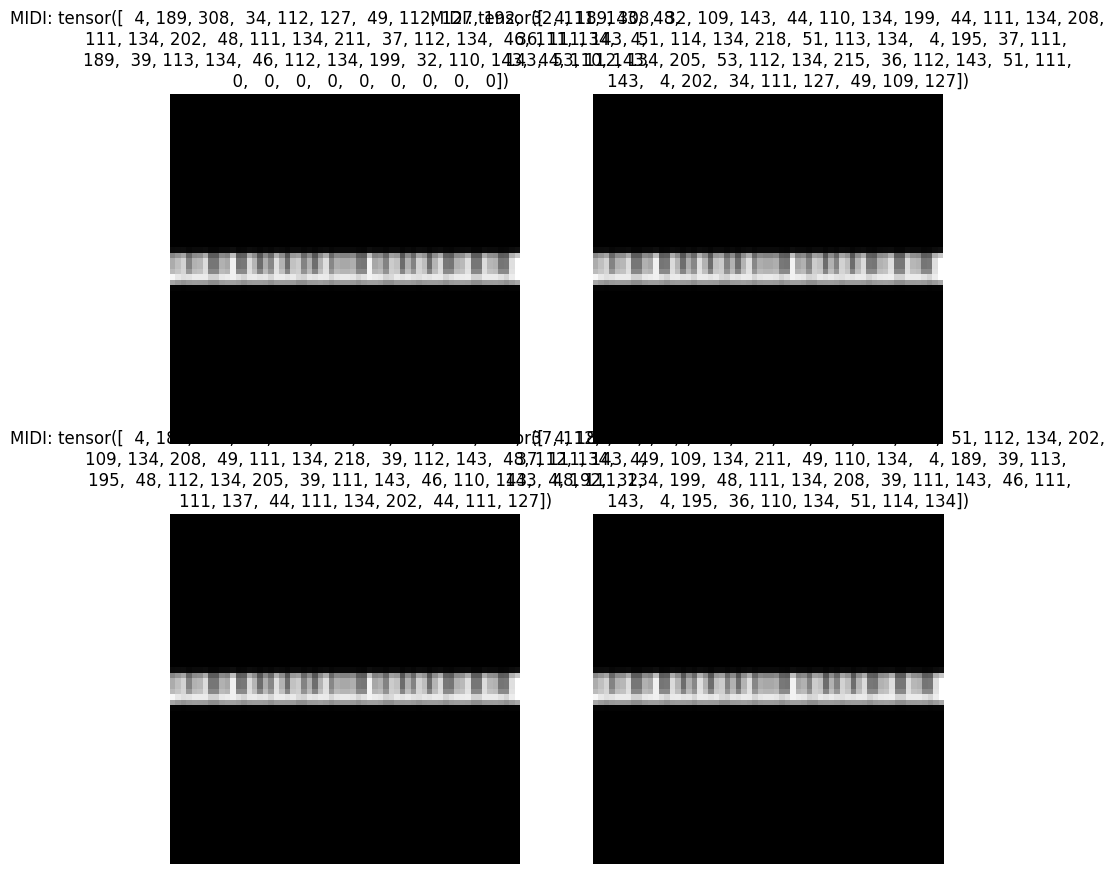

In [95]:
show_images_and_midi(dataloader)